In [5]:
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 폰트 경로 설정
font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 전체 matplotlib 폰트 설정
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False


In [1]:
from datetime import datetime
import numpy as np 
import pandas as pd 
import glob 
import random 
import os 

# kmjng
base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
# base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mUsageStats, shape = (45197, 3)
⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (60349

In [7]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_std': np.std(rssi_all) if rssi_all else np.nan,  # 표준편차 추가 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 
mWifi_df2

,subject_id,date,wifi_rssi_mean,wifi_rssi_std,wifi_rssi_min,wifi_rssi_max,wifi_detected_cnt
0,id01,2024-06-26,-70.196447,13.819975,-91,-19,957
1,id01,2024-06-27,-69.062937,15.855484,-92,-26,1144
2,id01,2024-06-28,-69.094064,15.291664,-92,-26,1095
3,id01,2024-06-29,-67.789668,17.572476,-91,-24,1355
4,id01,2024-06-30,-68.299911,16.210807,-90,-23,1127
...,...,...,...,...,...,...,...
680,id10,2024-09-21,-68.749416,15.031923,-92,-16,2139
681,id10,2024-09-22,-71.754617,12.700714,-89,-16,1895
682,id10,2024-09-24,-68.337821,14.834684,-93,-19,2451
683,id10,2024-09-25,-69.095631,14.685773,-92,-15,2060


### 분포 확인

수치형 컬럼: ['wifi_rssi_mean', 'wifi_rssi_std', 'wifi_rssi_min', 'wifi_rssi_max', 'wifi_detected_cnt']

=== wifi_rssi_mean 정규성 검정 ===
평균: -72.4568
표준편차: 4.7194
왜도(Skewness): -0.2715
첨도(Kurtosis): 0.0267

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.9704, p-value=0.000000
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=8.3856, p-value=0.015104
결과: 정규분포 아님
Jarque-Bera: 통계량=8.4376, p-value=0.014717
결과: 정규분포 아님
Kolmogorov-Smirnov: 통계량=0.0604, p-value=0.012855
결과: 정규분포 아님


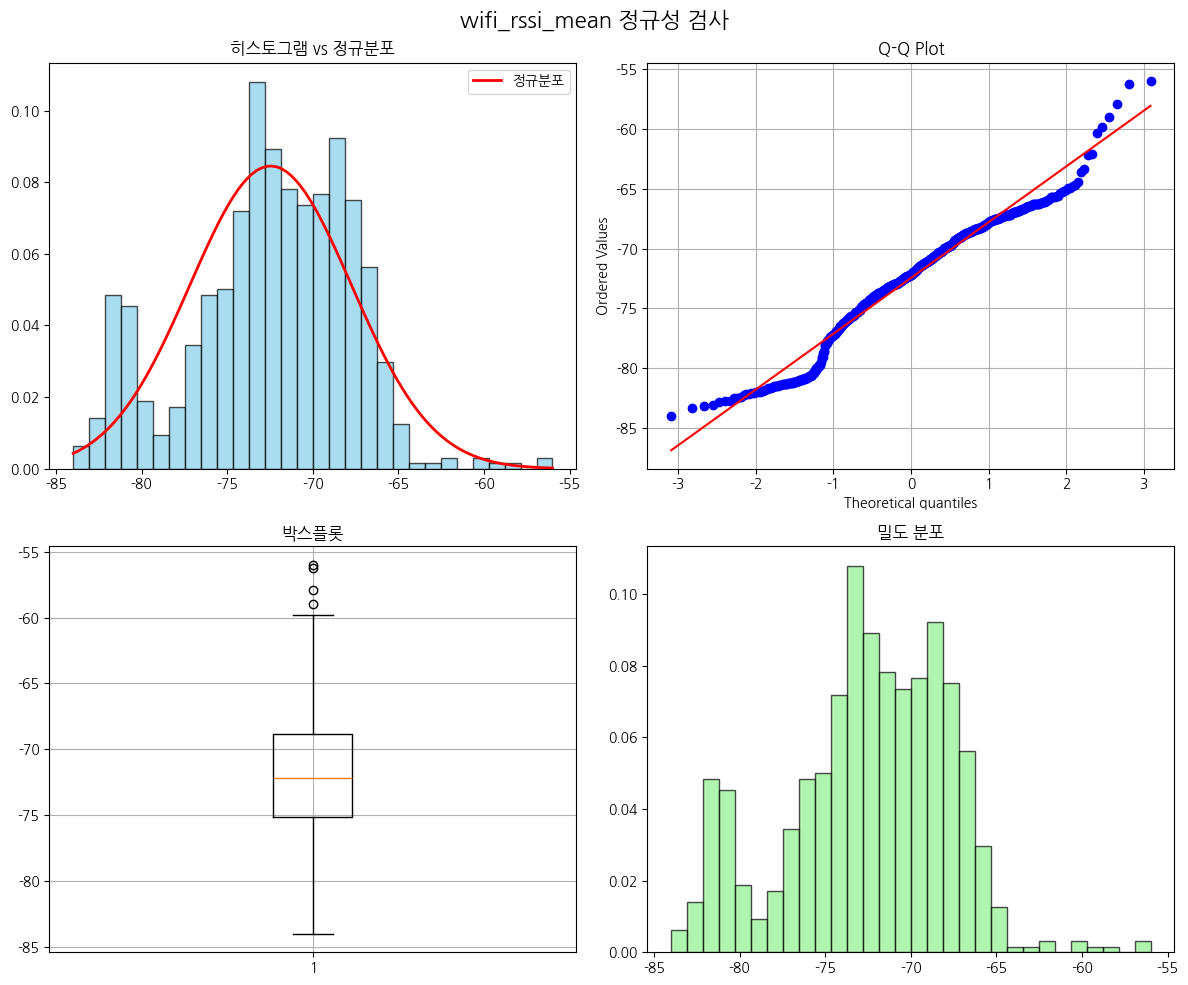


=== wifi_rssi_std 정규성 검정 ===
평균: 14.6259
표준편차: 2.1323
왜도(Skewness): -0.1035
첨도(Kurtosis): -0.1322

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.9821, p-value=0.000000
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=1.6382, p-value=0.440820
결과: 정규분포 가능성
Jarque-Bera: 통계량=1.7213, p-value=0.422881
결과: 정규분포 가능성
Kolmogorov-Smirnov: 통계량=0.0635, p-value=0.007558
결과: 정규분포 아님


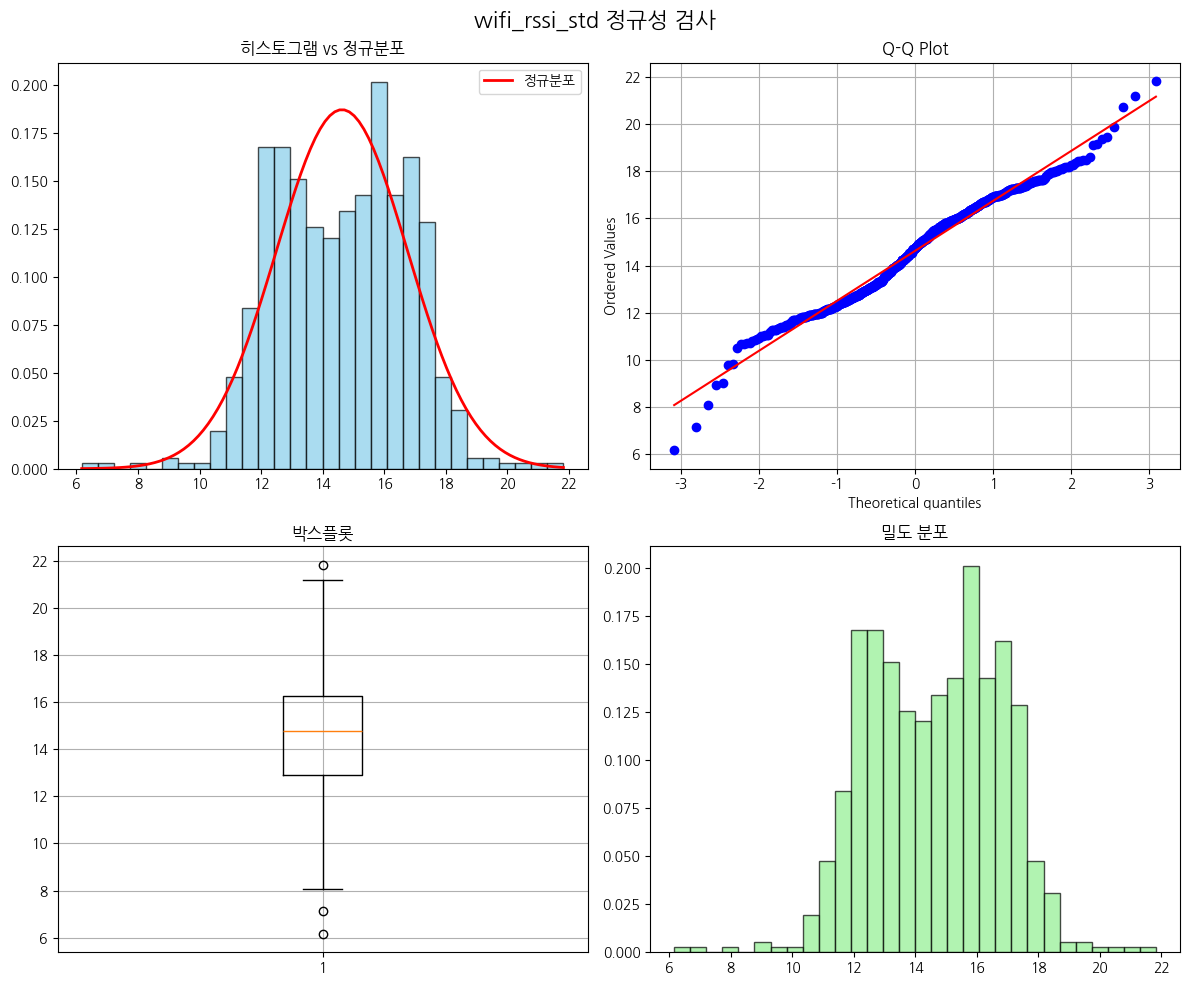


=== wifi_rssi_min 정규성 검정 ===
평균: -93.6350
표준편차: 3.0857
왜도(Skewness): 0.1502
첨도(Kurtosis): -0.4044

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.9388, p-value=0.000000
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=9.4271, p-value=0.008973
결과: 정규분포 아님
Jarque-Bera: 통계량=7.2422, p-value=0.026753
결과: 정규분포 아님
Kolmogorov-Smirnov: 통계량=0.1596, p-value=0.000000
결과: 정규분포 아님


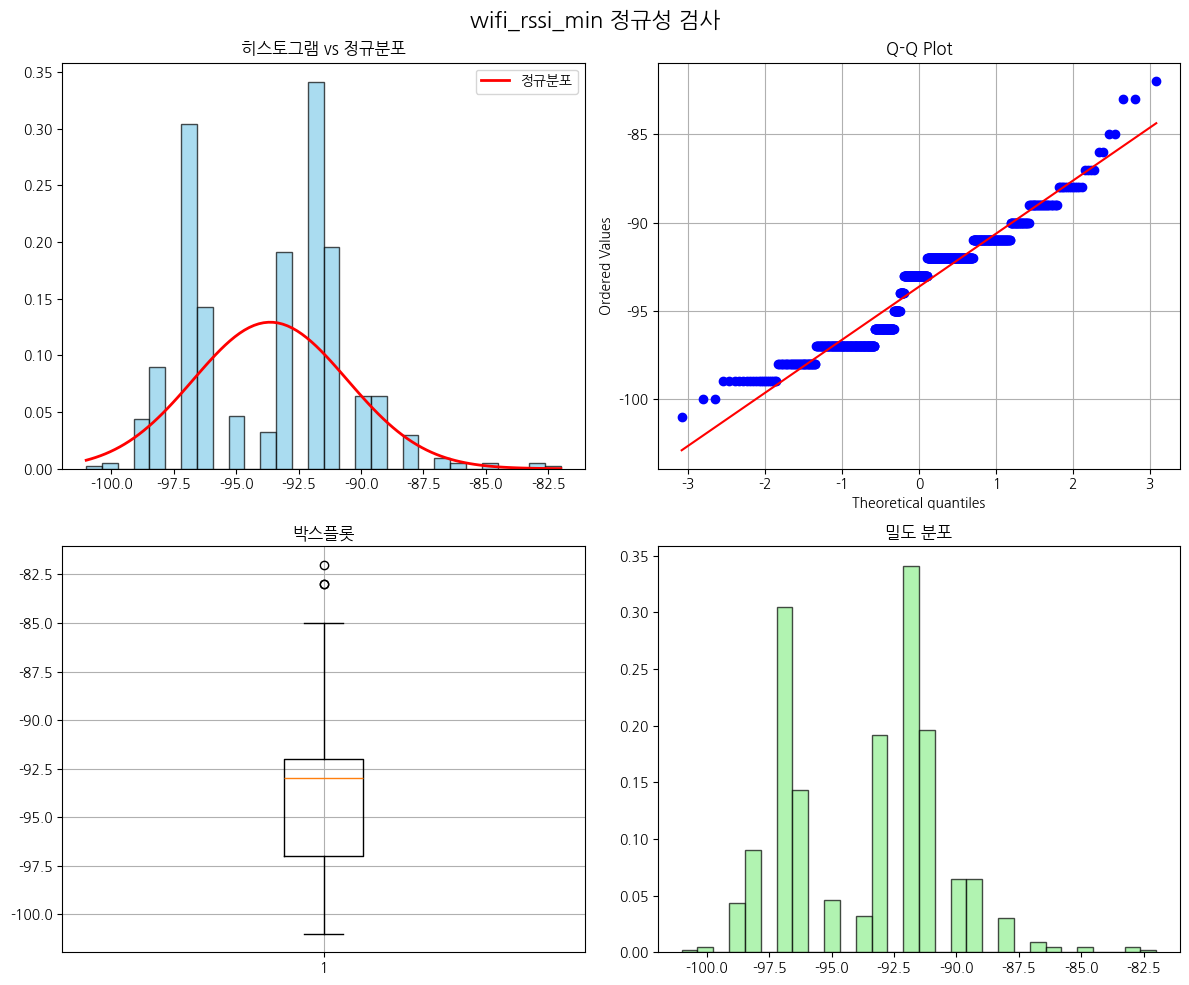


=== wifi_rssi_max 정규성 검정 ===
평균: -26.0540
표준편차: 10.4015
왜도(Skewness): 0.9084
첨도(Kurtosis): 1.4822

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.8938, p-value=0.000000
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=96.7957, p-value=0.000000
결과: 정규분포 아님
Jarque-Bera: 통계량=156.9102, p-value=0.000000
결과: 정규분포 아님
Kolmogorov-Smirnov: 통계량=0.1206, p-value=0.000000
결과: 정규분포 아님


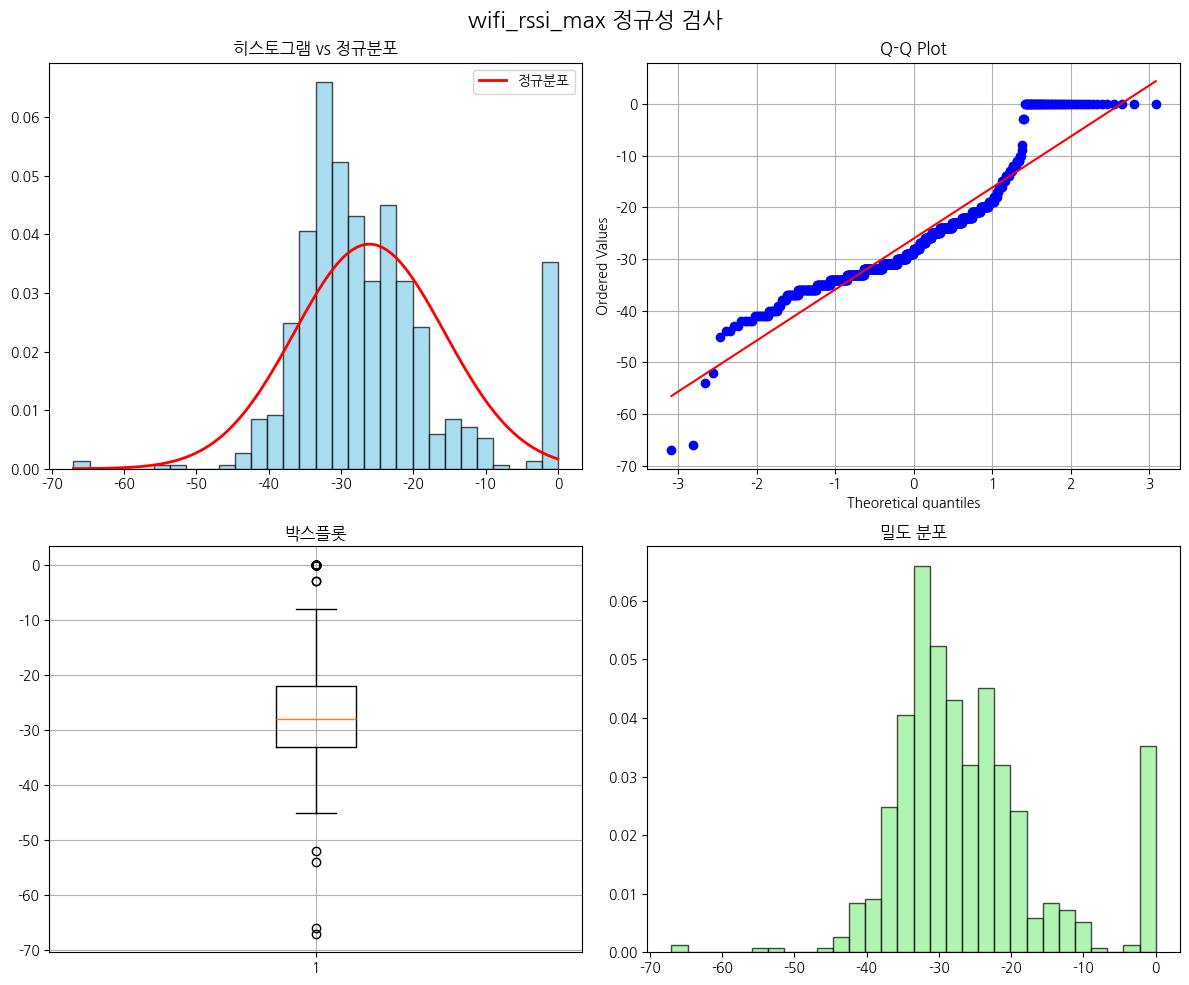


=== wifi_detected_cnt 정규성 검정 ===
평균: 1854.0234
표준편차: 1042.5476
왜도(Skewness): 0.6217
첨도(Kurtosis): -0.3345

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.9382, p-value=0.000000
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=42.6614, p-value=0.000000
결과: 정규분포 아님
Jarque-Bera: 통계량=47.3139, p-value=0.000000
결과: 정규분포 아님
Kolmogorov-Smirnov: 통계량=0.1370, p-value=0.000000
결과: 정규분포 아님


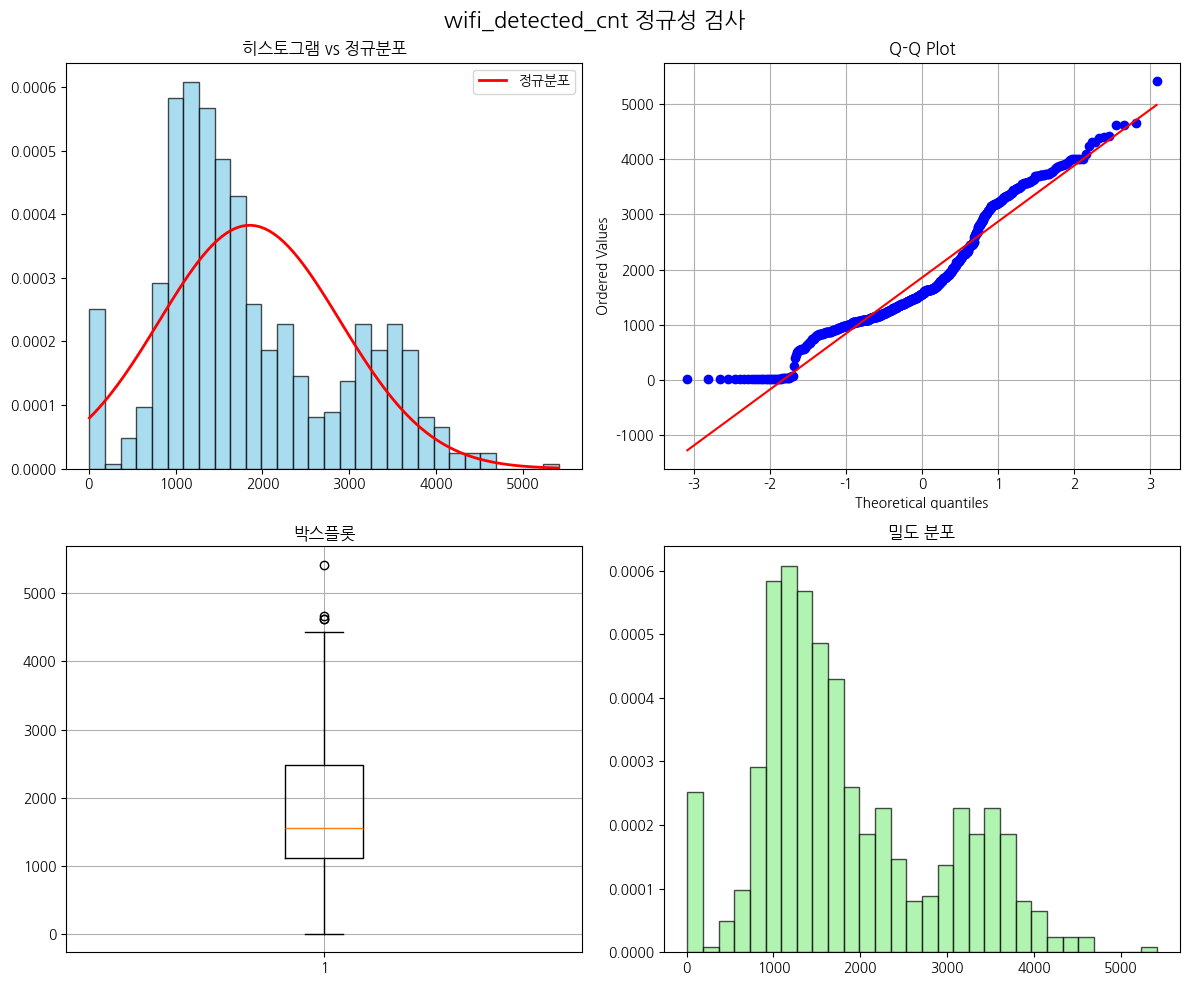


정규성 검정 해석 가이드:
- p-value > 0.05: 정규분포일 가능성이 높음
- p-value ≤ 0.05: 정규분포가 아닐 가능성이 높음
- Q-Q Plot에서 점들이 직선에 가까우면 정규분포
- 왜도가 0에 가까우면 대칭적, 첨도가 3에 가까우면 정규분포와 유사


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# 예시 데이터 (실제 데이터로 바꿔주세요)
df = mWifi_df2.copy()

# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"수치형 컬럼: {numeric_cols}")

def normality_tests(data, column_name):
    """다양한 정규성 검정을 수행하는 함수"""
    print(f"\n=== {column_name} 정규성 검정 ===")
    
    # 기본 통계량
    print(f"평균: {data.mean():.4f}")
    print(f"표준편차: {data.std():.4f}")
    print(f"왜도(Skewness): {stats.skew(data):.4f}")
    print(f"첨도(Kurtosis): {stats.kurtosis(data):.4f}")
    
    print("\n--- 정규성 검정 결과 ---")
    
    # 1. Shapiro-Wilk 검정 (샘플 크기 < 5000)
    if len(data) < 5000:
        stat, p_value = shapiro(data)
        print(f"Shapiro-Wilk: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    
    # 2. D'Agostino-Pearson 검정
    try:
        stat, p_value = normaltest(data)
        print(f"D'Agostino-Pearson: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("D'Agostino-Pearson: 데이터가 부족하여 수행 불가")
    
    # 3. Jarque-Bera 검정
    try:
        stat, p_value = jarque_bera(data)
        print(f"Jarque-Bera: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("Jarque-Bera: 데이터가 부족하여 수행 불가")
    
    # 4. Kolmogorov-Smirnov 검정
    try:
        # 데이터를 표준화
        normalized_data = (data - data.mean()) / data.std()
        stat, p_value = kstest(normalized_data, 'norm')
        print(f"Kolmogorov-Smirnov: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("Kolmogorov-Smirnov: 수행 불가")

def plot_normality_check(data, column_name):
    """정규성 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{column_name} 정규성 검사', fontsize=16)
    
    # 1. 히스토그램 + 정규분포 곡선
    axes[0,0].hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    axes[0,0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='정규분포')
    axes[0,0].set_title('히스토그램 vs 정규분포')
    axes[0,0].legend()
    
    # 2. Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot')
    axes[0,1].grid(True)
    
    # 3. 박스플롯
    axes[1,0].boxplot(data)
    axes[1,0].set_title('박스플롯')
    axes[1,0].grid(True)
    
    # 4. 밀도 플롯
    axes[1,1].hist(data, bins=30, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,1].set_title('밀도 분포')
    
    plt.tight_layout()
    plt.show()

# 각 수치형 컬럼에 대해 정규성 검정 수행
for col in numeric_cols:
    if df[col].notna().sum() > 2:  # 최소 3개 이상의 데이터가 있을 때만
        normality_tests(df[col].dropna(), col)
        plot_normality_check(df[col].dropna(), col)

# 전체 요약
print("\n" + "="*50)
print("정규성 검정 해석 가이드:")
print("- p-value > 0.05: 정규분포일 가능성이 높음")
print("- p-value ≤ 0.05: 정규분포가 아닐 가능성이 높음")
print("- Q-Q Plot에서 점들이 직선에 가까우면 정규분포")
print("- 왜도가 0에 가까우면 대칭적, 첨도가 3에 가까우면 정규분포와 유사")
print("="*50)

### NaN 확인

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def analyze_missing_hours(mWifi_df):
    """
    각 subject_id별로 누락된 시간대를 분석하는 함수
    """
    results = {}
    
    # timestamp 컬럼을 datetime으로 변환 (필요한 경우)
    if not pd.api.types.is_datetime64_any_dtype(mWifi_df['timestamp']):
        mWifi_df['timestamp'] = pd.to_datetime(mWifi_df['timestamp'])
    
    # 각 subject_id별로 분석
    for subject_id in sorted(mWifi_df['subject_id'].unique()):
        # 해당 ID의 데이터만 필터링
        id_data = mWifi_df[mWifi_df['subject_id'] == subject_id].copy()
        
        if len(id_data) == 0:
            continue
            
        # 날짜별로 그룹화하여 분석
        id_data['date'] = id_data['timestamp'].dt.date
        id_data['hour'] = id_data['timestamp'].dt.hour
        
        date_analysis = {}
        
        # 각 날짜별로 누락된 시간 확인
        for date in sorted(id_data['date'].unique()):
            daily_data = id_data[id_data['date'] == date]
            present_hours = set(daily_data['hour'].unique())
            all_hours = set(range(24))  # 0~23시
            missing_hours = sorted(all_hours - present_hours)
            
            date_analysis[date] = {
                'missing_hours': missing_hours,
                'missing_count': len(missing_hours),
                'coverage_rate': (24 - len(missing_hours)) / 24 * 100
            }
        
        results[subject_id] = date_analysis
    
    return results

def print_missing_hours_summary(mWifi_df):
    """
    누락 시간대 분석 결과를 요약해서 출력
    """
    results = analyze_missing_hours(mWifi_df)
    
    print("=== WiFi 데이터 시간대 누락 분석 요약 ===")
    print(f"{'ID':<6} {'날짜':<12} {'누락시간수':<10} {'커버리지(%)':<12} {'누락시간대'}")
    print("-" * 80)
    
    for subject_id in sorted(results.keys()):
        date_data = results[subject_id]
        for date, info in sorted(date_data.items()):
            missing_str = ', '.join(map(str, info['missing_hours'])) if info['missing_hours'] else "없음"
            if len(missing_str) > 40:  # 너무 길면 축약
                missing_str = missing_str[:37] + "..."
            
            print(f"{subject_id:<6} {str(date):<12} {info['missing_count']:<10} {info['coverage_rate']:<11.1f} {missing_str}")
    
    return results

def analyze_id_missing_pattern(mWifi_df, target_id=None):
    """
    특정 ID 또는 모든 ID의 누락 패턴을 상세 분석
    """
    results = analyze_missing_hours(mWifi_df)
    
    if target_id:
        ids_to_analyze = [target_id] if target_id in results else []
        if not ids_to_analyze:
            print(f"ID '{target_id}'를 찾을 수 없습니다.")
            return
    else:
        ids_to_analyze = sorted(results.keys())
    
    for subject_id in ids_to_analyze:
        print(f"\n=== {subject_id} 상세 분석 ===")
        date_data = results[subject_id]
        
        total_missing = 0
        total_days = len(date_data)
        
        for date, info in sorted(date_data.items()):
            total_missing += info['missing_count']
            
            print(f"날짜: {date}")
            print(f"  - 누락된 시간: {info['missing_count']}시간")
            
            if info['missing_hours']:
                # 연속된 누락 시간 구간 찾기
                missing_ranges = []
                start = info['missing_hours'][0]
                end = start
                
                for i in range(1, len(info['missing_hours'])):
                    if info['missing_hours'][i] == end + 1:
                        end = info['missing_hours'][i]
                    else:
                        if start == end:
                            missing_ranges.append(f"{start}시")
                        else:
                            missing_ranges.append(f"{start}~{end}시")
                        start = info['missing_hours'][i]
                        end = start
                
                # 마지막 구간 추가
                if start == end:
                    missing_ranges.append(f"{start}시")
                else:
                    missing_ranges.append(f"{start}~{end}시")
                
                print(f"  - 누락 시간대: {', '.join(missing_ranges)}")
            else:
                print(f"  - 누락된 시간: 없음 (완전한 데이터)")
            
            print(f"  - 커버리지: {info['coverage_rate']:.1f}%")
            print()
        
        # 전체 통계
        avg_missing = total_missing / total_days if total_days > 0 else 0
        print(f"전체 통계:")
        print(f"  - 총 분석 일수: {total_days}일")
        print(f"  - 총 누락 시간: {total_missing}시간")
        print(f"  - 일평균 누락: {avg_missing:.1f}시간")
        print(f"  - 전체 평균 커버리지: {(24*total_days - total_missing)/(24*total_days)*100:.1f}%")

# 사용 예시
def quick_missing_check(mWifi_df, target_id):
    """
    특정 ID의 누락 시간 빠른 체크
    """
    results = analyze_missing_hours(mWifi_df)
    
    if target_id not in results:
        print(f"ID '{target_id}'를 찾을 수 없습니다.")
        return
    
    print(f"=== {target_id} 누락 시간 체크 ===")
    date_data = results[target_id]
    
    for date, info in sorted(date_data.items()):
        status = "완전" if info['missing_count'] == 0 else f"{info['missing_count']}시간 누락"
        print(f"{date}: {status} (커버리지 {info['coverage_rate']:.1f}%)")

# 실행 예시:
print_missing_hours_summary(mWifi_df)  # 전체 요약

=== WiFi 데이터 시간대 누락 분석 요약 ===
ID     날짜           누락시간수      커버리지(%)      누락시간대
--------------------------------------------------------------------------------
id01   2024-06-26   12         50.0        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
id01   2024-06-27   1          95.8        3
id01   2024-06-28   1          95.8        2
id01   2024-06-29   0          100.0       없음
id01   2024-06-30   4          83.3        0, 2, 3, 4
id01   2024-07-01   2          91.7        1, 3
id01   2024-07-02   2          91.7        1, 3
id01   2024-07-03   0          100.0       없음
id01   2024-07-04   1          95.8        2
id01   2024-07-05   1          95.8        2
id01   2024-07-06   4          83.3        1, 3, 4, 5
id01   2024-07-07   4          83.3        2, 4, 5, 6
id01   2024-07-08   1          95.8        3
id01   2024-07-09   3          87.5        0, 2, 3
id01   2024-07-10   1          95.8        3
id01   2024-07-12   1          95.8        2
id01   2024-07-13   2          91.7        

{'id01': {datetime.date(2024, 6, 26): {'missing_hours': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11],
   'missing_count': 12,
   'coverage_rate': 50.0},
  datetime.date(2024, 6, 27): {'missing_hours': [3],
   'missing_count': 1,
   'coverage_rate': 95.83333333333334},
  datetime.date(2024, 6, 28): {'missing_hours': [2],
   'missing_count': 1,
   'coverage_rate': 95.83333333333334},
  datetime.date(2024, 6, 29): {'missing_hours': [],
   'missing_count': 0,
   'coverage_rate': 100.0},
  datetime.date(2024, 6, 30): {'missing_hours': [0, 2, 3, 4],
   'missing_count': 4,
   'coverage_rate': 83.33333333333334},
  datetime.date(2024, 7, 1): {'missing_hours': [1, 3],
   'missing_count': 2,
   'coverage_rate': 91.66666666666666},
  datetime.date(2024, 7, 2): {'missing_hours': [1, 3],
   'missing_count': 2,
   'coverage_rate': 91.66666666666666},
  datetime.date(2024, 7, 3): {'missing_hours': [],
   'missing_count': 0,
   'coverage_rate': 100.0},
  datetime.

In [15]:
# analyze_id_missing_pattern(mWifi_df, 'id08')  # id01 상세 분석
# quick_missing_check(mWifi_df, 'id08')  # id01 빠른 체크

### 파생변수 추가 및 누락비율 확인

In [17]:
import ast 
def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour
    
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        # 시간대별로 데이터 분리
        afternoon_data = group[(group['hour'] >= 12) & (group['hour'] < 18)]  # 12-18시
        night_data = group[(group['hour'] >= 18) & (group['hour'] < 24)]      # 18-24시  
        midnight_data = group[(group['hour'] >= 0) & (group['hour'] < 6)]     # 0-6시
        
        def extract_rssi(data):
            rssi_list = []
            for row in data['m_wifi']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                for ap in parsed: 
                    try: 
                        rssi = int(ap['rssi']) 
                        rssi_list.append(rssi) 
                    except: 
                        continue 
            return rssi_list
        
        # 각 시간대별 RSSI 추출
        afternoon_rssi = extract_rssi(afternoon_data)
        night_rssi = extract_rssi(night_data)
        midnight_rssi = extract_rssi(midnight_data)
        
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            # 오후 (12-18시)
            'afternoon_wifi_rssi_mean': np.mean(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_rssi_std': np.std(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_detected_cnt': len(afternoon_rssi),
            
            # 밤 (18-24시)  
            'night_wifi_rssi_mean': np.mean(night_rssi) if night_rssi else np.nan,
            'night_wifi_rssi_std': np.std(night_rssi) if night_rssi else np.nan,
            'night_wifi_detected_cnt': len(night_rssi),
            
            # 자정 (0-6시)
            'midnight_wifi_rssi_mean': np.mean(midnight_rssi) if midnight_rssi else np.nan,
            'midnight_wifi_rssi_std': np.std(midnight_rssi) if midnight_rssi else np.nan,
            'midnight_wifi_detected_cnt': len(midnight_rssi),
        }) 
    return pd.DataFrame(results) 

mWifi_df3 = process_mWifi(mWifi_df) 
mWifi_df3.head(5)

,subject_id,date,afternoon_wifi_rssi_mean,afternoon_wifi_rssi_std,afternoon_wifi_detected_cnt,night_wifi_rssi_mean,night_wifi_rssi_std,night_wifi_detected_cnt,midnight_wifi_rssi_mean,midnight_wifi_rssi_std,midnight_wifi_detected_cnt
0,id01,2024-06-26,-72.036217,12.386738,497,-68.208696,14.965465,460,NaN,NaN,0
1,id01,2024-06-27,-73.362229,12.714125,323,-67.161585,18.331004,328,-66.764444,17.744422,225
2,id01,2024-06-28,-72.929260,12.480267,311,-65.041935,17.819929,310,-68.272189,15.859121,169
3,id01,2024-06-29,-71.326034,14.117021,411,-64.490272,19.074116,257,-58.535849,21.612358,265
4,id01,2024-06-30,-73.211581,12.737271,449,-63.260417,18.910743,288,-60.000000,20.566964,24


In [31]:
import pandas as pd

def filter_high_nan_features(df, threshold=0.2):
    """NaN 비율이 임계값 이상인 컬럼 제거 (간단 버전)"""
    nan_ratio = df.isnull().mean()  # mean()이 sum()/len()보다 간단
    keep_cols = nan_ratio[nan_ratio <= threshold].index
    
    print(f"제거된 컬럼: {df.shape[1] - len(keep_cols)}개")
    print(f"남은 컬럼: {len(keep_cols)}개")
    
    return df[keep_cols]
mWifi_df3 = filter_high_nan_features(mWifi_df3)

제거된 컬럼: 0개
남은 컬럼: 9개
